# Segmentation

Name: Syed Zain Raza

## Loading Images

### Building-Only Images: `entry-P10`

In [1]:
import glob
from typing import List

In [2]:
BASE_DATA_PATH = "./SfM_quality_evaluation/Benchmarking_Camera_Calibration_2008"
subset_names1 = ["entry-P10"]
file_ext_pattern = "*.jpg"

In [3]:
def aggregate_image_paths(
    base_data_path: str,
    image_subset_paths: List[str],
    file_ext_pattern: str,
) -> List[str]:
    """
    Look up all the images we care about using a file paths pattern. 
    Returns the file paths in a 1D Python list.
    """
    all_img_paths = list()

    for subset in image_subset_paths:
        pattern_for_subset_images = "/".join(
            [base_data_path, subset, "images", file_ext_pattern]
        )
        all_img_paths.extend(glob.glob(pattern_for_subset_images))

    return all_img_paths

In [4]:
ten_building_only_img_paths = aggregate_image_paths(BASE_DATA_PATH, subset_names1, file_ext_pattern)

In [5]:
ten_building_only_img_paths

['./SfM_quality_evaluation/Benchmarking_Camera_Calibration_2008/entry-P10/images/0006.jpg',
 './SfM_quality_evaluation/Benchmarking_Camera_Calibration_2008/entry-P10/images/0007.jpg',
 './SfM_quality_evaluation/Benchmarking_Camera_Calibration_2008/entry-P10/images/0005.jpg',
 './SfM_quality_evaluation/Benchmarking_Camera_Calibration_2008/entry-P10/images/0004.jpg',
 './SfM_quality_evaluation/Benchmarking_Camera_Calibration_2008/entry-P10/images/0000.jpg',
 './SfM_quality_evaluation/Benchmarking_Camera_Calibration_2008/entry-P10/images/0001.jpg',
 './SfM_quality_evaluation/Benchmarking_Camera_Calibration_2008/entry-P10/images/0003.jpg',
 './SfM_quality_evaluation/Benchmarking_Camera_Calibration_2008/entry-P10/images/0002.jpg',
 './SfM_quality_evaluation/Benchmarking_Camera_Calibration_2008/entry-P10/images/0009.jpg',
 './SfM_quality_evaluation/Benchmarking_Camera_Calibration_2008/entry-P10/images/0008.jpg']

In [6]:
from util import ops

In [7]:
building_only_img_arrays = [
    ops.load_image(
        img_path,
        return_grayscale=False,
        return_array=True,  # dictates that we want to have a NumPy array
        verbosity=False,
    )
    for img_path in ten_building_only_img_paths
]
# for convenience
building_only_img_map = dict(zip(ten_building_only_img_paths, building_only_img_arrays))

### Building and Tractor Images

- let `castle-P30` = "training" images for the framework
- let `castle-P19` = "hold-out" images in the framework

In [8]:
train_img_paths = aggregate_image_paths(
    BASE_DATA_PATH, ["castle-P30"], file_ext_pattern
)

test_img_paths = aggregate_image_paths(
    BASE_DATA_PATH, ["castle-P19"], file_ext_pattern
)

In [10]:
train_img_arrays = [
    ops.load_image(
        img_path,
        return_grayscale=False,
        return_array=True,  # dictates that we want to have a NumPy array
        verbosity=False,
    )
    for img_path in train_img_paths
]
# for convenience
train_img_map = dict(zip(train_img_paths, train_img_arrays))

In [11]:
test_img_arrays = [
    ops.load_image(
        img_path,
        return_grayscale=False,
        return_array=True,  # dictates that we want to have a NumPy array
        verbosity=False,
    )
    for img_path in test_img_paths
]
# for convenience
test_img_map = dict(zip(test_img_paths, test_img_arrays))

## Implementation

### Imports

In [12]:
import cv2
import numpy as np
from util.clustering import KMeans
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

### Training

Goal is for us to have a trained estimator that, when given a set of pixel-wise features of an image, can produce a binary mask we can use for segmenting out our tractor.

#### Step 1: Feature Engineering

We'll create a Global BoW representation of the images. This step is mainly just intended as dimensionality reduction. We will do separately for each color channel, to preserve color info.

In [13]:
building_only_img_arrays = np.array(building_only_img_arrays)

In [14]:
building_only_img_arrays.shape

(10, 2048, 3072, 3)

##### DEPRECATED [TODO Delete] Dims Reduction using PCA

In [15]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


def preprocess_and_reduce_dims(imgs: np.ndarray, pca_components: int = 10) -> np.ndarray:
    # preprocessing - flattening
    imgs_red_channel, imgs_green_channel, imgs_blue_channel = (
        building_only_img_arrays[:, :, :, 0],
        building_only_img_arrays[:, :, :, 1],
        building_only_img_arrays[:, :, :, 2],
    )
    imgs_red_channel_flat = imgs_red_channel.reshape(imgs_red_channel.shape[0], -1)
    imgs_green_channel_flat = imgs_green_channel.reshape(
        imgs_green_channel.shape[0], -1
    )
    imgs_blue_channel_flat = imgs_blue_channel.reshape(imgs_blue_channel.shape[0], -1)

    # # preprocessing - normalization
    # imgs_red_channel_flat = imgs_red_channel_flat / 255.0
    # imgs_green_channel_flat = imgs_green_channel_flat / 255.0
    # imgs_blue_channel_flat = imgs_blue_channel_flat / 255.0

    # # preprocessing - centering
    # imgs_red_channel_flat_scaled = StandardScaler().fit_transform(imgs_red_channel_flat)
    # imgs_green_channel_flat_scaled = StandardScaler().fit_transform(
    #     imgs_green_channel_flat
    # )
    # imgs_blue_channel_flat_scaled = StandardScaler().fit_transform(
    #     imgs_blue_channel_flat
    # )

    # dims reduction with PCA - # of components is arbitrary
    imgs_red_channel_reduced = PCA(n_components=pca_components).fit_transform(
        imgs_red_channel_flat
    )
    imgs_green_channel_reduced = PCA(n_components=pca_components).fit_transform(
        imgs_green_channel_flat
    )
    imgs_blue_channel_reduced = PCA(n_components=pca_components).fit_transform(
        imgs_blue_channel_flat
    )

    return (
        imgs_red_channel_reduced,
        imgs_green_channel_reduced,
        imgs_blue_channel_reduced,
    )

In [68]:
building_only_img_pca = preprocess_and_reduce_dims(building_only_img_arrays)

In [69]:
(
    building_only_img_pca_red,
    building_only_img_pca_green,
    building_only_img_pca_blue,
) = building_only_img_pca

##### Feature Engineering using SIFT

For the purpose of dimensionality reduction, we detect, describe, and cluster features of the image using SIFT. 

Each of the cluster labels is associated with a point, and falls into one of 35 buckets. When that bucket will be labelled as a tractor, all the associated points should be colored as such. Therefore we will also need some way to associate a bucket index, with a set of keypoint coords.

In [92]:
from collections import defaultdict
from typing import List, Tuple, Union

import cv2
import numpy as np

from util.clustering import KMeans


def _extract_sift_features(
    img: np.ndarray,
    mode: str = "detection",
) -> Union[List[cv2.KeyPoint], np.ndarray, Tuple[List[cv2.KeyPoint], np.ndarray]]:
    """
    Feature extraction using SIFT.
    Can be used for either detection or description.
    """
    sift = cv2.SIFT_create()
    img_normalized = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype("uint8")
    keypoints, descriptors = sift.detectAndCompute(img_normalized, None)
    if mode == "detection":
        return keypoints  # list of keypoint objs
    elif mode == "description":
        return descriptors  # ndarray
    elif mode == "both":
        return (keypoints, descriptors)


def create_global_visual_word_vocabulary(
    imgs: List[np.ndarray],
    n_clusters: int = 100,
) -> KMeans:
    descriptors_list = []
    for img in imgs:
        descriptors = _extract_sift_features(img, mode="description")
        if descriptors is not None:
            descriptors_list.extend(descriptors)

    descriptors_arr = np.array(descriptors_list)
    print(descriptors_arr.shape)

    # create full set of visual words
    kmeans = KMeans(k=n_clusters)
    kmeans.fit(descriptors_arr)
    return kmeans


def build_histograms(imgs: np.ndarray, kmeans: KMeans) -> np.ndarray:
    """Build histograms for EACH image using visual words, acting as a global representation."""
    histograms = []
    for img in imgs:
        detected_keypoints, descriptors = _extract_sift_features(img, mode="both")
        # map bucket indices back to pixel coords in the image
        buckets_to_pixel_coords = defaultdict(list)
        if descriptors is not None:
            labels = np.array(kmeans.predict(descriptors))
            print(f"Labels shape: {labels.shape}")
            histogram, _ = np.histogram(labels, bins=range(kmeans.num_clusters + 1))
            histograms.append(histogram)
            # fill buckets_to_pixel_coords map
            for bucket_index, _ in enumerate(histogram):
                # search for every index pos "labels" with that as it's value
                pixel_indices = np.where(labels == bucket_index)
                pixel_coords = np.array(detected_keypoints)[pixel_indices]
                buckets_to_pixel_coords[bucket_index] = pixel_coords

        else:
            histograms.append(np.zeros(kmeans.num_clusters))

    return np.array(histograms), buckets_to_pixel_coords

In [93]:
building_only_img_arrays.shape

(10, 2048, 3072, 3)

In [95]:
# remember, this is just a KMeans object
visual_word_identifier_buildings_only = create_global_visual_word_vocabulary(
    building_only_img_arrays,
    n_clusters=35,  # arbitrary
)

building_only_descriptors, buckets_to_pixel_coords = build_histograms(
    building_only_img_arrays, visual_word_identifier_buildings_only
)

(71995, 128)
Labels shape: (7842,)
Labels shape: (7784,)
Labels shape: (6906,)
Labels shape: (6716,)
Labels shape: (7799,)
Labels shape: (7744,)
Labels shape: (7175,)
Labels shape: (7467,)
Labels shape: (5769,)
Labels shape: (6793,)


In [97]:
building_only_buckets_to_pixel_coords = buckets_to_pixel_coords

In [98]:
building_only_buckets_to_pixel_coords

defaultdict(list,
            {0: array([< cv2.KeyPoint 0x17313bc00>, < cv2.KeyPoint 0x17313b1b0>,
                    < cv2.KeyPoint 0x17313ac70>, < cv2.KeyPoint 0x173139a70>,
                    < cv2.KeyPoint 0x17319ccc0>, < cv2.KeyPoint 0x17319c870>,
                    < cv2.KeyPoint 0x1731a0180>, < cv2.KeyPoint 0x1731a6910>,
                    < cv2.KeyPoint 0x1731ac630>, < cv2.KeyPoint 0x1731ae0d0>,
                    < cv2.KeyPoint 0x1731ac270>, < cv2.KeyPoint 0x1731b56b0>,
                    < cv2.KeyPoint 0x1731c3e70>, < cv2.KeyPoint 0x1731c5b60>,
                    < cv2.KeyPoint 0x1731c4690>, < cv2.KeyPoint 0x1731ce370>,
                    < cv2.KeyPoint 0x1731d4900>, < cv2.KeyPoint 0x1731da3d0>],
                   dtype=object),
             1: array([< cv2.KeyPoint 0x173145b60>, < cv2.KeyPoint 0x173194b10>,
                    < cv2.KeyPoint 0x173dd9950>, < cv2.KeyPoint 0x173dd86c0>,
                    < cv2.KeyPoint 0x173dda040>, < cv2.KeyPoint 0x173dd8120>,
     

In [99]:
# remember, this is just a KMeans object
visual_word_identifier_buildings_and_tractor = create_global_visual_word_vocabulary(
    train_img_arrays,
    n_clusters=35,  # arbitrary
)

(
    building_and_tractor_train_descriptors, 
    building_and_tractor_buckets_to_pixel_coord,
) = build_histograms(
    train_img_arrays,
    visual_word_identifier_buildings_and_tractor
)

(176065, 128)
Labels shape: (7045,)
Labels shape: (7541,)
Labels shape: (7177,)
Labels shape: (5359,)
Labels shape: (8298,)
Labels shape: (7336,)
Labels shape: (7873,)
Labels shape: (8549,)
Labels shape: (5573,)
Labels shape: (9842,)
Labels shape: (4364,)
Labels shape: (4334,)
Labels shape: (6152,)
Labels shape: (6831,)
Labels shape: (3516,)
Labels shape: (7703,)
Labels shape: (5546,)
Labels shape: (3902,)
Labels shape: (4813,)
Labels shape: (4619,)
Labels shape: (4954,)
Labels shape: (3509,)
Labels shape: (3624,)
Labels shape: (4913,)
Labels shape: (7637,)
Labels shape: (4067,)
Labels shape: (4078,)
Labels shape: (7749,)
Labels shape: (4162,)
Labels shape: (4999,)


In [100]:
building_and_tractor_train_descriptors[0].shape

(35,)

In [103]:
building_and_tractor_train_descriptors[0].shape[0] == len(
    building_and_tractor_buckets_to_pixel_coord
)

True

#### Step 2: Clustering the "Building-Only" Images

We use mean shift clustering, as we want an unbiased picture on how closely clustered the features of the building tend to be.

In [104]:
from typing import Dict, Tuple

import numpy as np


def mean_shift(
    data: np.ndarray,
    window_size: int = 1.0,
    max_iter: int = 100,
    convergence_threshold: float = 1e-4,
) -> Dict[int, Tuple[Tuple[float], List[np.ndarray]]]:
    """
    Unsupervised clustering of n-dimensional feature vectors using Mean-Shift.
    Returns a dictionary in the form: {cluster_label -> (cluster_centroid_coords, list_of_member_img_indices)}.
    """
    # 1: find the "hill" each point should climb
    n_points = data.shape[0]

    # Initialize random means for each data point
    hills = list()

    for i in range(n_points):
        current_point = data[i, :]
        means = [current_point]

        for _ in range(max_iter):
            # Find points within the bandwidth distance from the current mean
            last_mean = means[-1]
            within_window = np.linalg.norm(data - last_mean, axis=1) < window_size

            # Update mean using the points within the bandwidth
            new_mean = np.mean(data[within_window], axis=0)
            means.append(new_mean)

            # Check for convergence
            if np.linalg.norm(last_mean - new_mean) < convergence_threshold:
                break

        hills.append(means)

    # 2: Assign cluster labels based on the final means
    unique_means = list(set([tuple(hill[-1]) for hill in hills]))
    cluster_labels_to_points = dict()
    cluster_coords_to_labels = dict()
    for cluster_label in range(len(unique_means)):
        cluster_labels_to_points[cluster_label] = list()
        cluster_coords_to_labels[unique_means[cluster_label]] = cluster_label

    for i, hill in enumerate(hills):
        # map this point to the specific cluster
        mean = hill[-1]
        original_point = hill[0]
        label = cluster_coords_to_labels[tuple(mean)]
        cluster_labels_to_points[label].append(i)

    # bring it all together: label -> centroid, list of original pts
    all_cluster_data = dict()
    for centroid_coords, label in cluster_coords_to_labels.items():
        original_pts = cluster_labels_to_points[label]
        all_cluster_data[label] = (centroid_coords, original_pts)

    return all_cluster_data

In [39]:
def compute_and_report_clusters(
    data: np.ndarray,
    window_size: int = 1.0,
    max_iter: int = 100,
    convergence_threshold: float = 1e-4,
) -> Dict[int, Tuple[Tuple[float], List[np.ndarray]]]:
    """Convenience wrapper around mean shift function."""
    clusters_of_descriptors = mean_shift(
        data=data,
        window_size=500,
        max_iter=1_000_000_0,
        convergence_threshold=1.5,
    )

    for label, pair in clusters_of_descriptors.items():
        print("==========================")
        print(f"Cluster #{label + 1} Report:")
        print(f"Centroid Coordinates: {pair[0]}")
        print(f"Cluster Members (by Image Index): {pair[1]}")

    return clusters_of_descriptors

Ignore the cell below:

In [60]:
building_only_img_pca[0].shape

(10, 10)

Pay attention to this cell:

In [40]:
building_only_descriptors.shape

(10, 35)

In [42]:
clusters_of_building_only_features = compute_and_report_clusters(
    data=building_only_descriptors,
    window_size=500,
    max_iter=1_000_000_0,
    convergence_threshold=1.5,
)

Cluster #1 Report:
Centroid Coordinates: (147.55555555555554, 3.2222222222222223, 1.0, 285.6666666666667, 1486.7777777777778, 9.333333333333334, 407.3333333333333, 331.77777777777777, 99.22222222222223, 0.0, 16.333333333333332, 63.0, 148.11111111111111, 0.2222222222222222, 220.33333333333334, 24.22222222222222, 677.5555555555555, 1246.0, 6.222222222222222, 92.66666666666667, 74.55555555555556, 3.3333333333333335, 548.6666666666666, 13.555555555555555, 6.555555555555555, 1.2222222222222223, 10.333333333333334, 112.77777777777777, 200.77777777777777, 1.2222222222222223, 0.2222222222222222, 593.8888888888889, 49.0, 291.1111111111111, 184.66666666666666)
Cluster Members (by Image Index): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


#### Step 2: Clustering the "Building-and-Tractor" Images

We use K-mean clustering, with `k = 1 + (whatever number of clusters was found by mean shift)`, when it was only the buildings. The hypothesis is this will lead to us finding a cluster that can be correlated back ot the tractor, by singling out whatever cluster is different from those found on the set of images with just buildings. 

In [61]:
kmeans = KMeans(k=1 + len(clusters_of_building_only_features))
centroid_coordinates = kmeans.fit(building_and_tractor_train_descriptors)

In [65]:
centroid_coordinates

{0: array([162.26666667, 162.8       ,   9.06666667,   1.        ,
         11.66666667,  18.26666667,  13.33333333, 330.13333333,
         86.2       ,  52.33333333, 139.26666667, 240.86666667,
        124.86666667, 645.        , 215.53333333,   1.13333333,
         73.2       ,   1.8       , 270.93333333, 234.93333333,
        298.26666667,  58.13333333,   5.73333333,   6.93333333,
          5.86666667,  14.86666667, 131.33333333,  37.53333333,
        259.93333333,   4.86666667,  51.53333333, 148.86666667,
         17.53333333, 124.93333333, 400.86666667]),
 1: array([ 296.33333333,  264.26666667,   31.13333333,    1.33333333,
          13.06666667,   25.73333333,   25.6       ,  507.46666667,
         139.8       ,  100.13333333,  198.13333333,  550.86666667,
         187.2       , 1197.8       ,  366.93333333,    1.73333333,
         101.33333333,    3.33333333,  308.6       ,  337.8       ,
         568.73333333,  125.86666667,   14.73333333,   13.13333333,
          15.6       ,

In [62]:
from collections import Counter

Let's test this out - try to label the descriptors of one of the training images.

In [66]:
descriptor_1_labels = kmeans.predict(building_and_tractor_train_descriptors[0])

In [67]:
Counter(descriptor_1_labels)

Counter({0: 28, 1: 7})

So the 1 here should represent the tractor. But how do we display the segmentation of the image?

In [112]:
def get_pixel_coords_for_labelled_object(
    descriptor_labels, target_label, map_buckets_to_pixel_coord
):
    coords = list()
    for index, label in enumerate(descriptor_labels):
        if label == target_label:
            coords.extend(
                [
                    # OpenCV lists coords as (x, y), but we want to have them as (row, col)
                    (int(keypoint.pt[1]), int(keypoint.pt[0]))
                    for keypoint in map_buckets_to_pixel_coord[index]
                ]
            )

    return np.array(coords)

In [116]:
tractor_coords_training_img1 = get_pixel_coords_for_labelled_object(
    descriptor_1_labels,
    1,
    building_and_tractor_buckets_to_pixel_coord,
)

##### Visual Test of Segmentation

We'll do it on one of the training images.

In [118]:
import matplotlib.pyplot as plt

%matplotlib inline

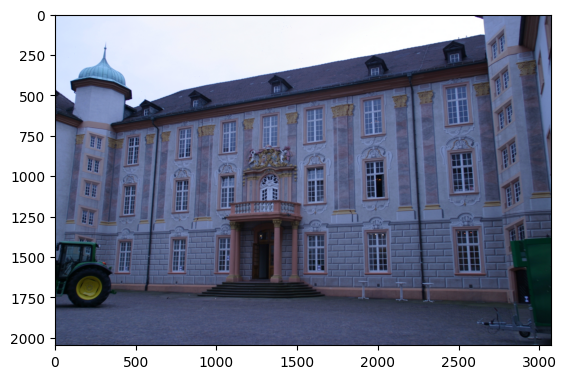

In [120]:
BLUE = np.array([0.0, 0.0, 255.0])
segmented_img = train_img_arrays[0].copy()
for row, col in tractor_coords_training_img1:
    segmented_img[row, col, :] = BLUE

plt.imshow(segmented_img)

So far, so not good. We will have to probably look for better descriptors to use I suppose.